# RecB dissociation rates in ΔrecA and RecB1080

In [1]:
from pyberries.data import DatasetPool, Fit, get_histogram
import seaborn.objects as so
from seaborn import plotting_context
import pandas as pd

data = (DatasetPool(path='D:\DanielThedie\BACMMAN\Timelapse',
                    dsList=['230725_1', '230725_2', '230126_DT23', '230719_1', '230719_2', '240424_1', '240612_1', '240620_1',
                            '230201_DT22', '230919_1', '240424_3', '240612_3',
                            '230126_DT21', '230919_2', '230920_2', '240606_1', '240606_3',
                            '230118_DT23', '230720_1', '230720_2', '230726_cipro30', '230824_1', '230829_1', '230201_DT23', '230504_2sec', '230718_2sec', '240424_2', '240612_2', '240620_2',
                            '221222_cipro30ngmL', '230802_DT22', '230808_DT22', '230914_1', '240424_4', '240612_4',
                            '230802_DT21', '230913_2', '230914_2', '240606_2', '240606_4'],
                    groups=['WT, 0 ng/mL', 'WT, 0 ng/mL', 'WT, 0 ng/mL', 'WT, 0 ng/mL', 'WT, 0 ng/mL', 'WT, 0 ng/mL', 'WT, 0 ng/mL', 'WT, 0 ng/mL',
                            'Δ$recA$, 0 ng/mL', 'Δ$recA$, 0 ng/mL', 'Δ$recA$, 0 ng/mL', 'Δ$recA$, 0 ng/mL',
                            'RecB$_{1080}$, 0 ng/mL', 'RecB$_{1080}$, 0 ng/mL', 'RecB$_{1080}$, 0 ng/mL', 'RecB$_{1080}$, 0 ng/mL', 'RecB$_{1080}$, 0 ng/mL',
                            'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL',
                            'Δ$recA$, 30 ng/mL', 'Δ$recA$, 30 ng/mL', 'Δ$recA$, 30 ng/mL', 'Δ$recA$, 30 ng/mL', 'Δ$recA$, 30 ng/mL', 'Δ$recA$, 30 ng/mL',
                            'RecB$_{1080}$, 30 ng/mL', 'RecB$_{1080}$, 30 ng/mL', 'RecB$_{1080}$, 30 ng/mL', 'RecB$_{1080}$, 30 ng/mL', 'RecB$_{1080}$, 30 ng/mL'],
                    filters={'all':'Frame < 50'},
                    metadata='DateTime',
                    rename_objects={'Spot_detection':'RecB_spots'},
                    rename_cols={'SpotCount':'RecBSpotCount'}
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .bin_column(col='Time_min', binsize=15, binlabels='left')
        .split_column(col='Group', new_cols=['Strain', 'Cipro'], delimiter=', ')
        )

Dataset 230725_1 (group WT, 0 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230725_2 (group WT, 0 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230126_DT23 (group WT, 0 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_1 (group WT, 0 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_2 (group WT, 0 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240424_1 (group WT, 0 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_1 (group WT, 0 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240620_1 (group WT, 0 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 230201_DT22 (group Δ$recA$, 0 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230919_1 (group Δ$recA$, 0 ng/mL): loaded objec

In [ ]:
data.describe(object_name='Bacteria_large')

## Cell lengths over time

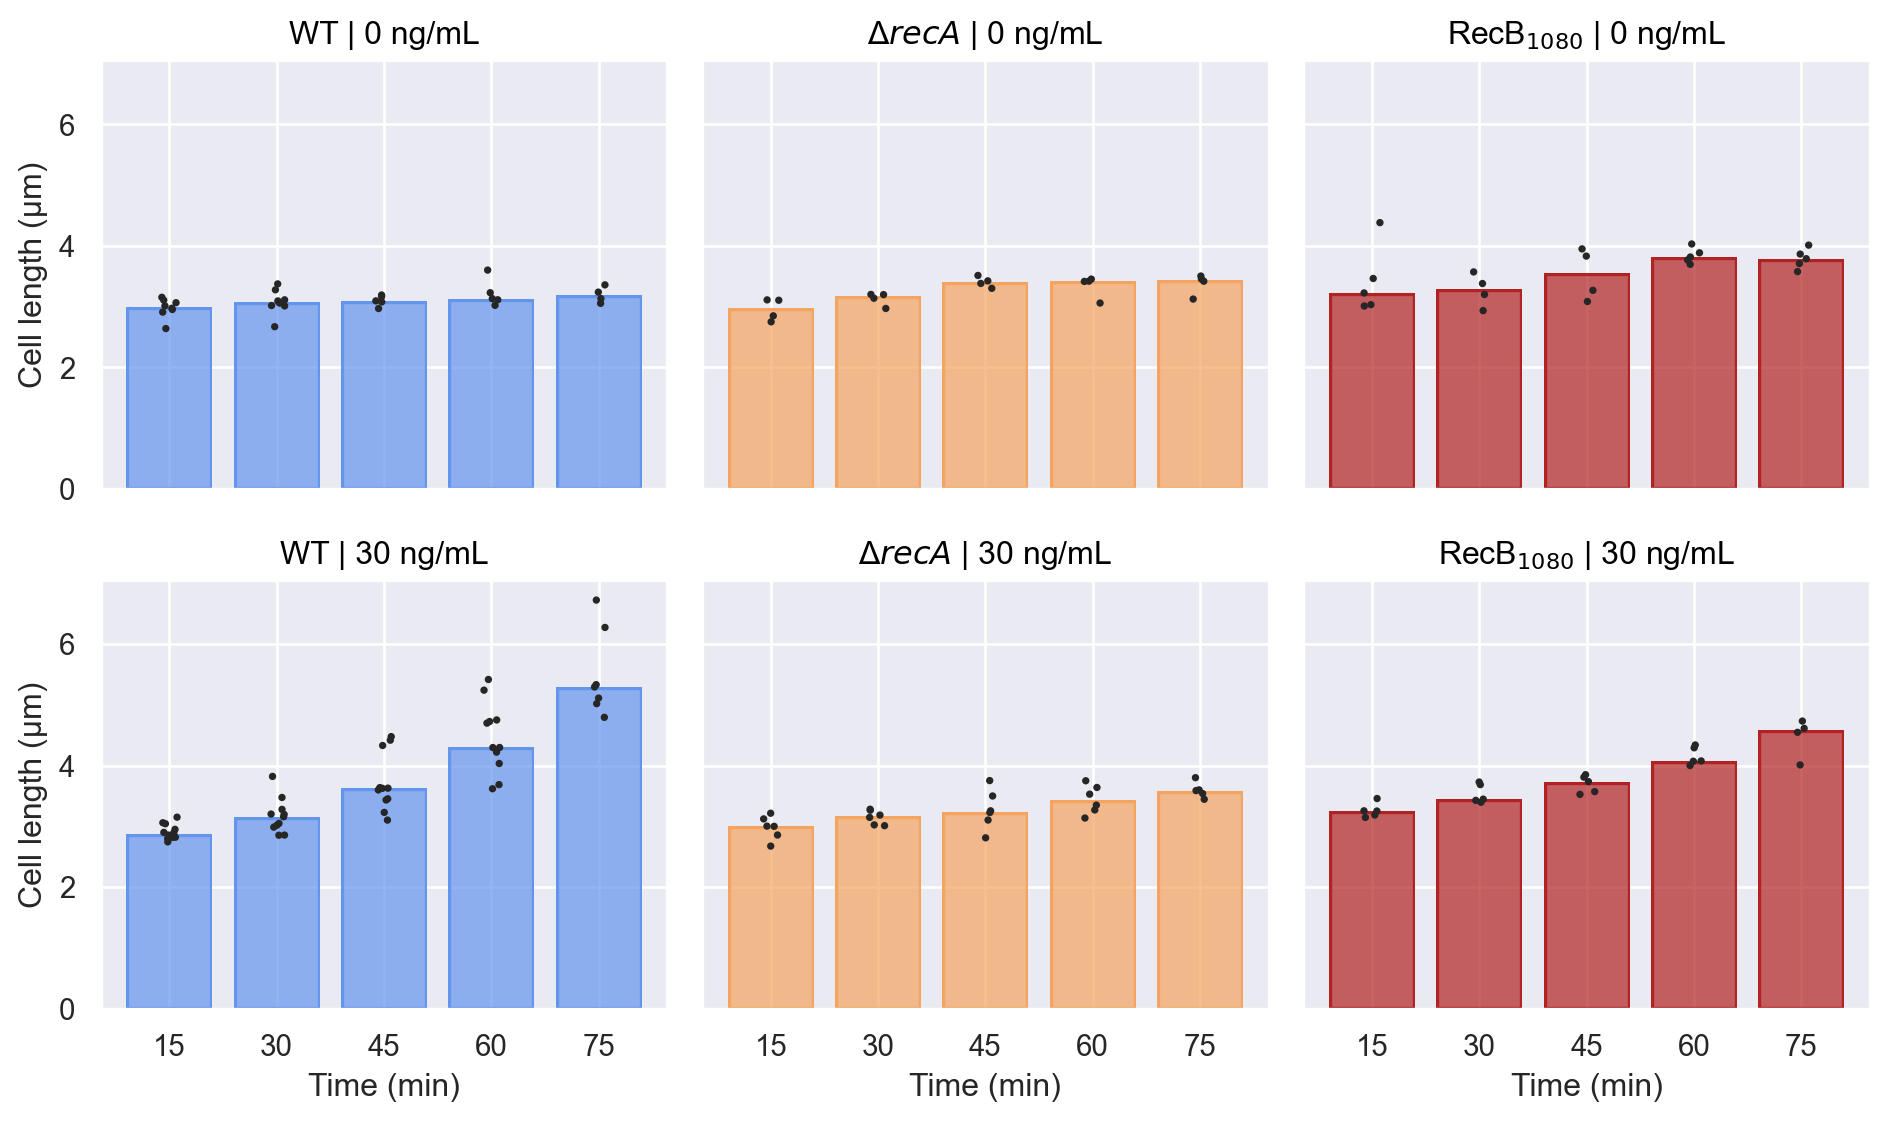

In [22]:
df = (data
      .Bacteria_large
      .groupby(['Group', 'Cipro', 'Strain', 'Dataset', 'Time_min_bin'], observed=True)
      .agg({'SpineLength':'mean'})
      .query('Time_min_bin <= 75')
      )

(
    so.Plot(df, x='Time_min_bin', y='SpineLength', color='Strain')
    .layout(size=(10, 6))
    .facet(row='Cipro', col='Strain', order={'col':['WT', 'Δ$recA$', 'RecB$_{1080}$']})
    .add(so.Bar(), so.Agg('median'), legend=False)
    .add(so.Dots(fillalpha=1, marker='.', color='k'), so.Jitter(), legend=False)
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick'], order=['WT', 'Δ$recA$', 'RecB$_{1080}$']),
            x=so.Continuous().tick(every=15))
    .label(x='Time (min)', y='Cell length (µm)')
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Mutants_cell_lengths.pdf', format='pdf', bbox_inches='tight')
)

/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommo

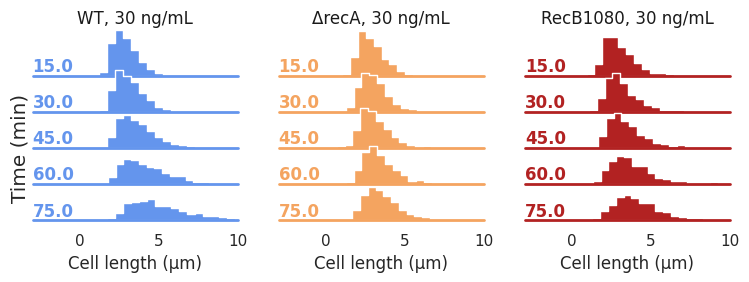

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = (data
      .Bacteria_large
      .query('Time_min_bin <= 75 and Cipro == "30 ng/mL"')
      )

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="Time_min_bin", col='Group', hue='Group', aspect=6, height=.5, palette=['cornflowerblue', 'sandybrown', 'firebrick'])
g.map(sns.histplot, 'SpineLength', binwidth=0.5, common_norm=False, stat='probability', alpha=1, element='step', edgecolor='w')
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(row, color, label):
      ax = plt.gca()
      ax.text(0, .2, row.iloc[0], fontweight="bold", color=color,
              ha="left", va="center", transform=ax.transAxes)
      if row.iloc[0] == 15.0:
            ax.text(.5, 1.2, label, color='k',
                  ha="center", va="center", transform=ax.transAxes)

g.map(label, 'Time_min_bin')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)
g.figure.supylabel('Time (min)', x=.1, y=.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel='Cell length (µm)', xlim=(-3, 10))
g.despine(bottom=True, left=True)
plt.show()

# plt.savefig(fname='D:\\DanielThedie\\Figures\\RecB_article_figures\\4_Mutants\\RecB_position.svg', format='svg', bbox_inches='tight')

## Bleaching rate fit

In [2]:
from pyberries.data import Fit

bleaching_fit = Fit(data.Bacteria_large, x='Frame', y='SNR', groupby=['Group', 'Strain', 'Cipro', 'Dataset'], model_type='monoexp_decay_offset', p0=[30000, 1, 0])

bleaching_rates = (bleaching_fit.parameters
                   .query('Parameter == "Rate"')
                   .assign(Adjusted_rate=lambda df: df.Value.div(2))  # Adjust rate to frame time
                   )

## RecB spot lifetime fit

### Bi-exponential fit

In [3]:
from pyberries.data import get_model

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset', 'Group', 'Strain', 'Cipro'], density=True, binlabels='left')
lifetime_fit = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay', bootstrap_samples=100,
                   groupby=['Dataset', 'Group', 'Strain', 'Cipro'], p0=[1, 1, 0.1, 0.1])

monoexp_decay = get_model('monoexp_decay')

lifetime_fit.data[['Fit_fast', 'Fit_slow']] = pd.DataFrame(columns=['Fit_fast', 'Fit_slow'], dtype='float64')
for ds, df in lifetime_fit.data.groupby('Dataset'):
    params = lifetime_fit.parameters.query('Dataset == @ds')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_1"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_1"').Value.iloc[0]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_2"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_2"').Value.iloc[0])
                  )
          )
    lifetime_fit.data.loc[lifetime_fit.data.Dataset == ds,:] = df

Group ('230725_1', 'WT, 0 ng/mL', 'WT', '0 ng/mL'): 1 iterations failed
Group ('230725_2', 'WT, 0 ng/mL', 'WT', '0 ng/mL'): 2 iterations failed
Group ('230126_DT23', 'WT, 0 ng/mL', 'WT', '0 ng/mL'): 3 iterations failed
Group ('230719_1', 'WT, 0 ng/mL', 'WT', '0 ng/mL'): 10 iterations failed


c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('240424_1', 'WT, 0 ng/mL', 'WT', '0 ng/mL'): 2 iterations failed
Group ('240612_1', 'WT, 0 ng/mL', 'WT', '0 ng/mL'): 34 iterations failed
Group ('240620_1', 'WT, 0 ng/mL', 'WT', '0 ng/mL'): 18 iterations failed


c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Group ('240424_3', 'Δ$recA$, 0 ng/mL', 'Δ$recA$', '0 ng/mL'): 9 iterations failed
Group ('230126_DT21', 'RecB$_{1080}$, 0 ng/mL', 'RecB$_{1080}$', '0 ng/mL'): 2 iterations failed


c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('240606_3', 'RecB$_{1080}$, 0 ng/mL', 'RecB$_{1080}$', '0 ng/mL'): 9 iterations failed
Group ('230118_DT23', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 5 iterations failed


c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('230726_cipro30', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 3 iterations failed
Group ('230824_1', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 3 iterations failed
Group ('230829_1', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 3 iterations failed
Group ('230201_DT23', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 4 iterations failed
Group ('230504_2sec', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 2 iterations failed
Group ('230718_2sec', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 1 iterations failed
Group ('240424_2', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 2 iterations failed
Group ('240612_2', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 3 iterations failed


c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('230802_DT22', 'Δ$recA$, 30 ng/mL', 'Δ$recA$', '30 ng/mL'): 1 iterations failed
Group ('240424_4', 'Δ$recA$, 30 ng/mL', 'Δ$recA$', '30 ng/mL'): 1 iterations failed
Group ('240612_4', 'Δ$recA$, 30 ng/mL', 'Δ$recA$', '30 ng/mL'): 6 iterations failed


c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('240606_4', 'RecB$_{1080}$, 30 ng/mL', 'RecB$_{1080}$', '30 ng/mL'): 1 iterations failed


#### Plot fits

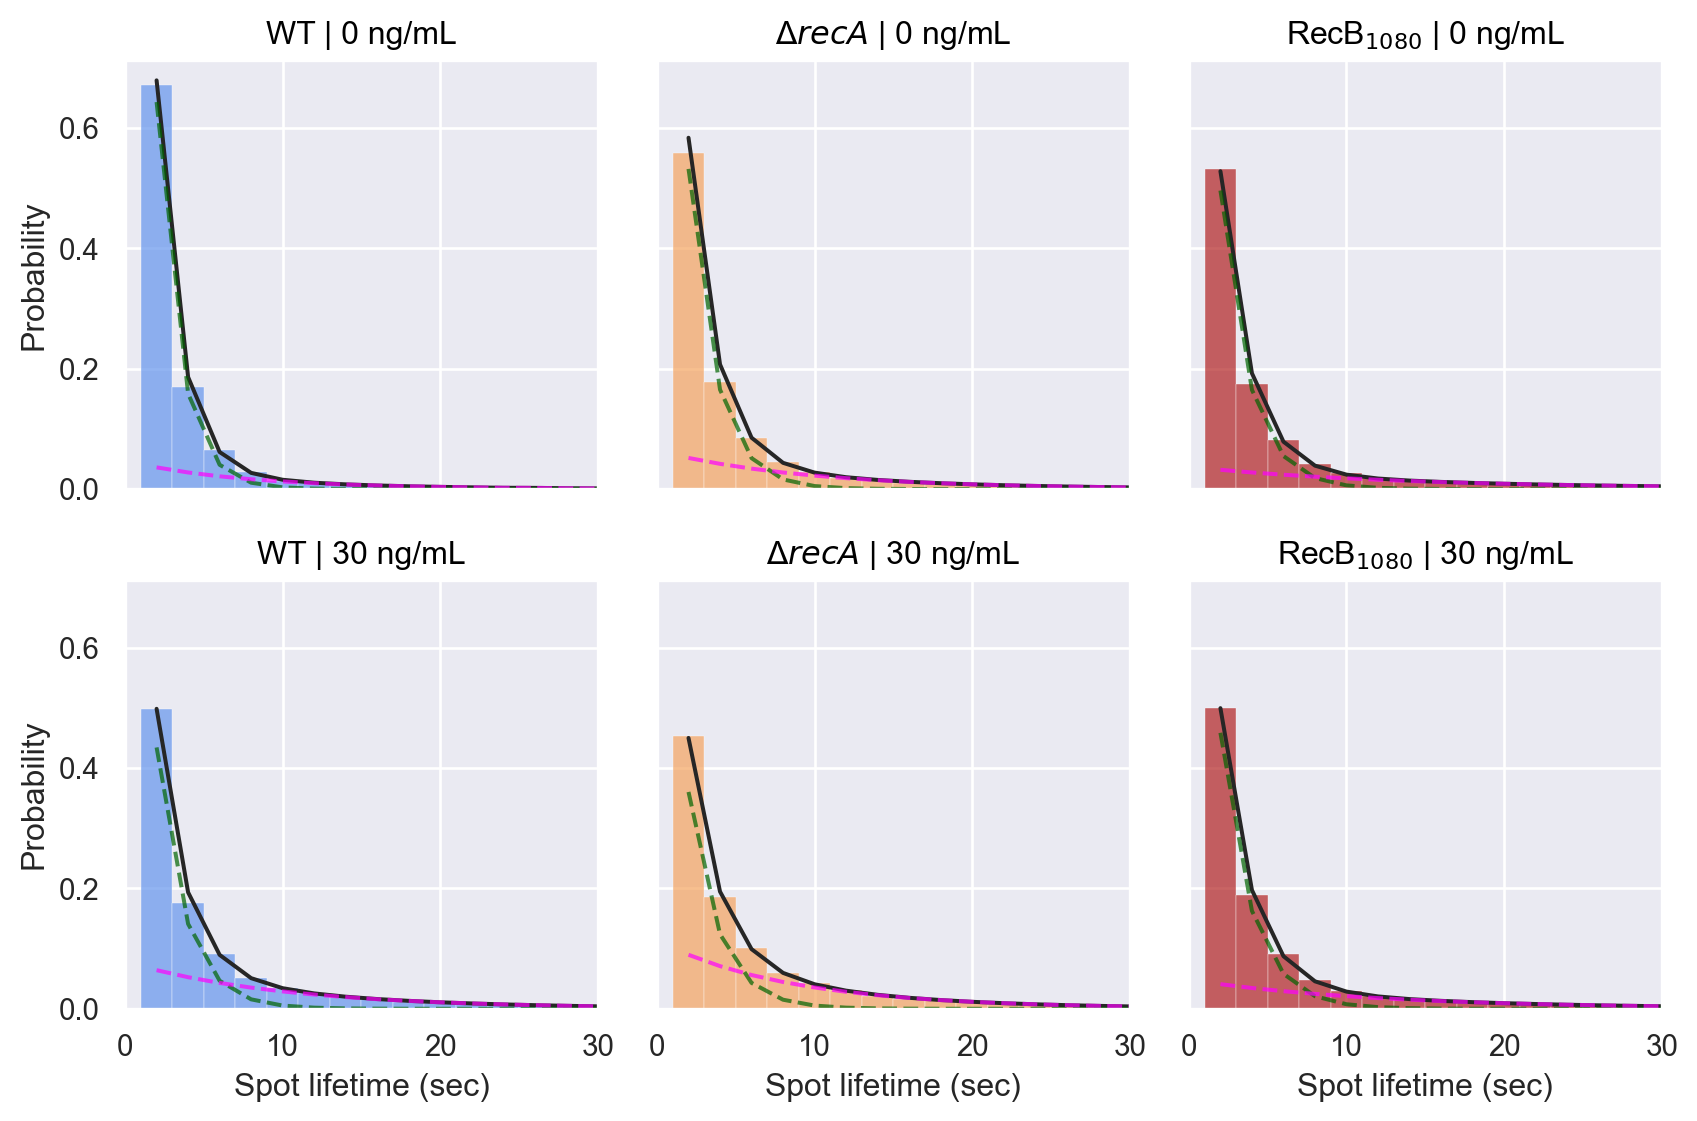

In [4]:
df = (lifetime_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength.mul(2))
      )

(
    so.Plot(df, x='TrackLength_s', color='Strain')
    .layout(size=(9, 6))
    .facet(col='Strain', row='Cipro')
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgreen', alpha=0.7), so.Agg(), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), so.Agg(), y='Fit_slow', legend=False)
    .limit(x=(0, 30), y=(None, None))
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick']))
    .label(x="Spot lifetime (sec)", y="Probability", color='')
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Mutants_RecB_fits.pdf', format='pdf', bbox_inches='tight')
)

#### Calculating RecB spot lifetimes from the rates

In [5]:
def split_column(df, col, new, delimiter):
        df[new] = (df[col]
                        .str.split(delimiter, expand=True)
                        )
        return df

lifetimes_biexp = (lifetime_fit
                   .parameters
                   .copy()
                   .pipe(lambda df: split_column(df, col='Parameter', new=['Parameter', 'Rate_type'], delimiter='_'))
                   .replace({'1':'Short', '2':'Long'})
                   .merge(bleaching_rates[['Dataset', 'Value']], on='Dataset', suffixes=(None, '_bleaching'))
                   .pipe(lambda df: pd.pivot_table(df, values=['Value'], index=['Group', 'Strain', 'Cipro', 'Dataset', 'Value_bleaching'], columns=['Parameter', 'Rate_type']))
                   .reset_index()
                   .assign(Lifetime_Short=lambda df: 1/(df.Value.Rate.Short - df.Value_bleaching) *2,
                           Lifetime_Long=lambda df: 1/(df.Value.Rate.Long - df.Value_bleaching) *2,
                           Population_Long=lambda df: df.Value.Amplitude.Long/(df.Value.Amplitude.Short+df.Value.Amplitude.Long) *100,
                           Population_Short=lambda df: 100 - df.Population_Long
                           )
                   .drop(columns=['Value', 'Value_bleaching'], level=0)
                   .droplevel(['Parameter', 'Rate_type'], axis=1)
                   .melt(id_vars=['Group', 'Strain', 'Cipro', 'Dataset'])
                   .pipe(lambda df: split_column(df, col='variable', new=['Parameter', 'Rate_type'], delimiter='_'))
                   .drop(columns='variable')
                   )

#### Make a pretty lifetimes table

In [7]:
def fuse_cols(df, cols, new, delimiter):
        df[new] = (df[cols]
                   .astype('str')
                   .agg(delimiter.join, axis=1)
                   )
        return df

df = (lifetimes_biexp
      .pipe(lambda df: pd.pivot_table(df, values='value', index=['Strain', 'Cipro', 'Dataset', 'Rate_type'], columns='Parameter'))
      .groupby(['Strain', 'Cipro', 'Rate_type'], observed=True)
      .agg(Lifetime_mean=('Lifetime', 'mean'),
           Lifetime_std=('Lifetime', 'std'),
           Population_mean=('Population', 'mean'),
           Population_std=('Population', 'std')
           )
      .round(2)
      .reset_index()
      .assign(Strain=lambda df: df.Strain
                          .astype('category')
                          .cat.set_categories(['WT', 'Δ$recA$', 'RecB$_{1080}$'], ordered=True))
      .sort_values('Strain')
      .set_index(['Strain','Cipro','Rate_type'])
      )

display(df)

Lifetime_mean  Lifetime_std  \
Strain        Cipro    Rate_type                                
WT            0 ng/mL  Long               12.88          7.66   
                       Short               1.49          0.22   
              30 ng/mL Long               13.66          2.85   
                       Short               1.88          0.26   
Δ$recA$       0 ng/mL  Long               13.44          3.09   
                       Short               1.79          0.09   
              30 ng/mL Long               11.98          3.24   
                       Short               2.00          0.21   
RecB$_{1080}$ 0 ng/mL  Long               32.97         23.86   
                       Short               1.92          0.11   
              30 ng/mL Long               19.51          7.27   
                       Short               2.05          0.21   

                                  Population_mean  Population_std  
Strain        Cipro    Rate_type                                   
WT            0 ng/mL  Long                  1.63            0.82  
                       Short                98.37            0.82  
              30 ng/mL Long                  5.53            1.22  
                       Short                94.47            1.22  
Δ$recA$       0 ng/mL  Long                  3.67            1.29  
                       Short                96.33            1.29  
              30 ng/mL Long                 10.10            3.33  
                       Short                89.90            3.33  
RecB$_{1080}$ 0 ng/mL  Long                  2.46            0.94  
                       Short                97.54            0.94  
              30 ng/mL Long                  3.62            0.75  
                       Short                96.38            0.75

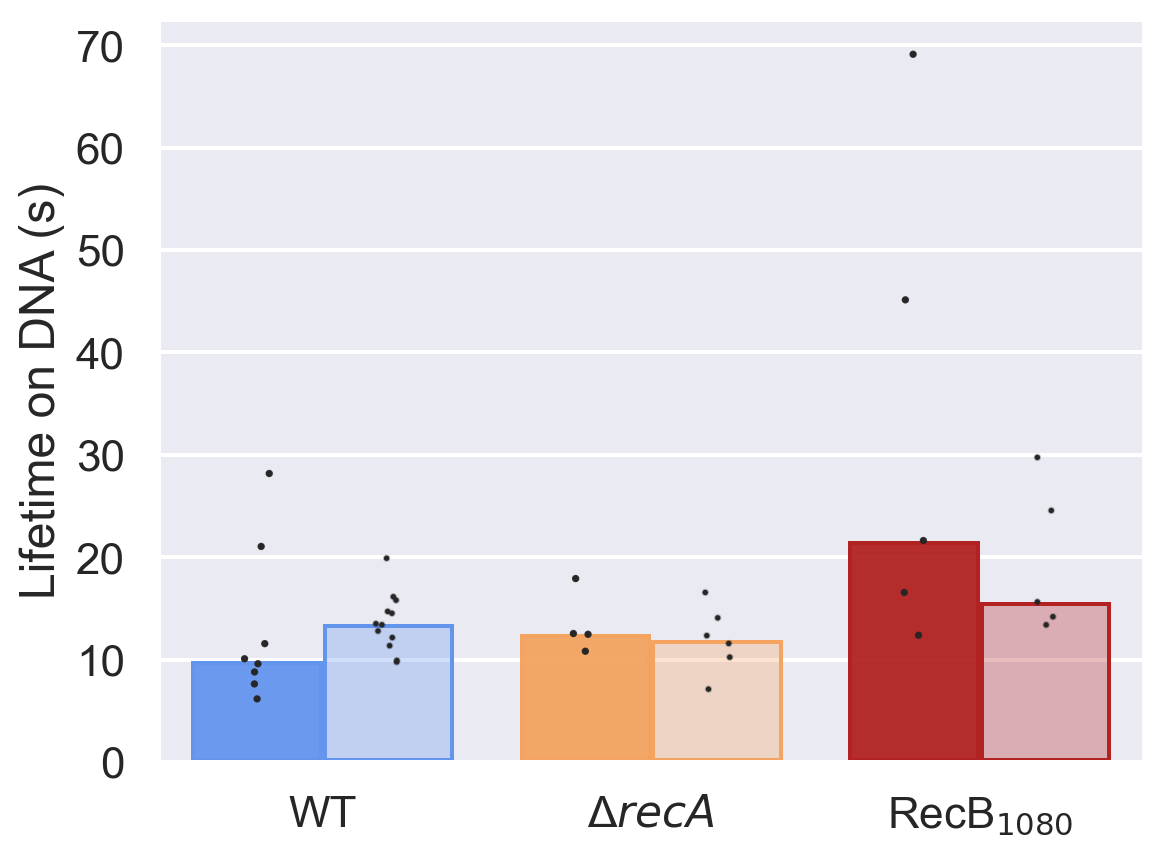

In [9]:
df = (lifetimes_biexp
      .replace({'Fast':'Short', 'Slow':'Long'})
      .query('Parameter == "Lifetime"  and Rate_type == "Long"')
      )

(
    so.Plot(df, x='Strain', y='value', color='Strain', alpha='Cipro')
    .add(so.Bar(), so.Agg('median'), so.Dodge(by=['alpha']), legend=False)
    .add(so.Dots(marker='.', color='k', fillalpha=1), so.Dodge(by=['alpha']), so.Jitter(), legend=False)
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick'],
                            order=['WT', 'Δ$recA$', 'RecB$_{1080}$']),
           x=so.Nominal(order=['WT', 'Δ$recA$', 'RecB$_{1080}$'])
           )
    .share(y='row')
    .limit(y=(None, None))
    .label(x="", y="Lifetime on DNA (s)", color='', title='', alpha='Ciprofloxacin')
    .theme(plotting_context('talk'))
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/4_Mutants/RecB_lifetimes.svg', format='svg', bbox_inches='tight')
)

## Estimate the rate of RecB recruitment to DNA

DSB_rate     
                     mean  std
Strain  Cipro                 
WT      0 ng/mL       0.9  0.7
        30 ng/mL      5.4  2.4
Δ$recA$ 0 ng/mL       3.6  1.7
        30 ng/mL     13.3  5.1

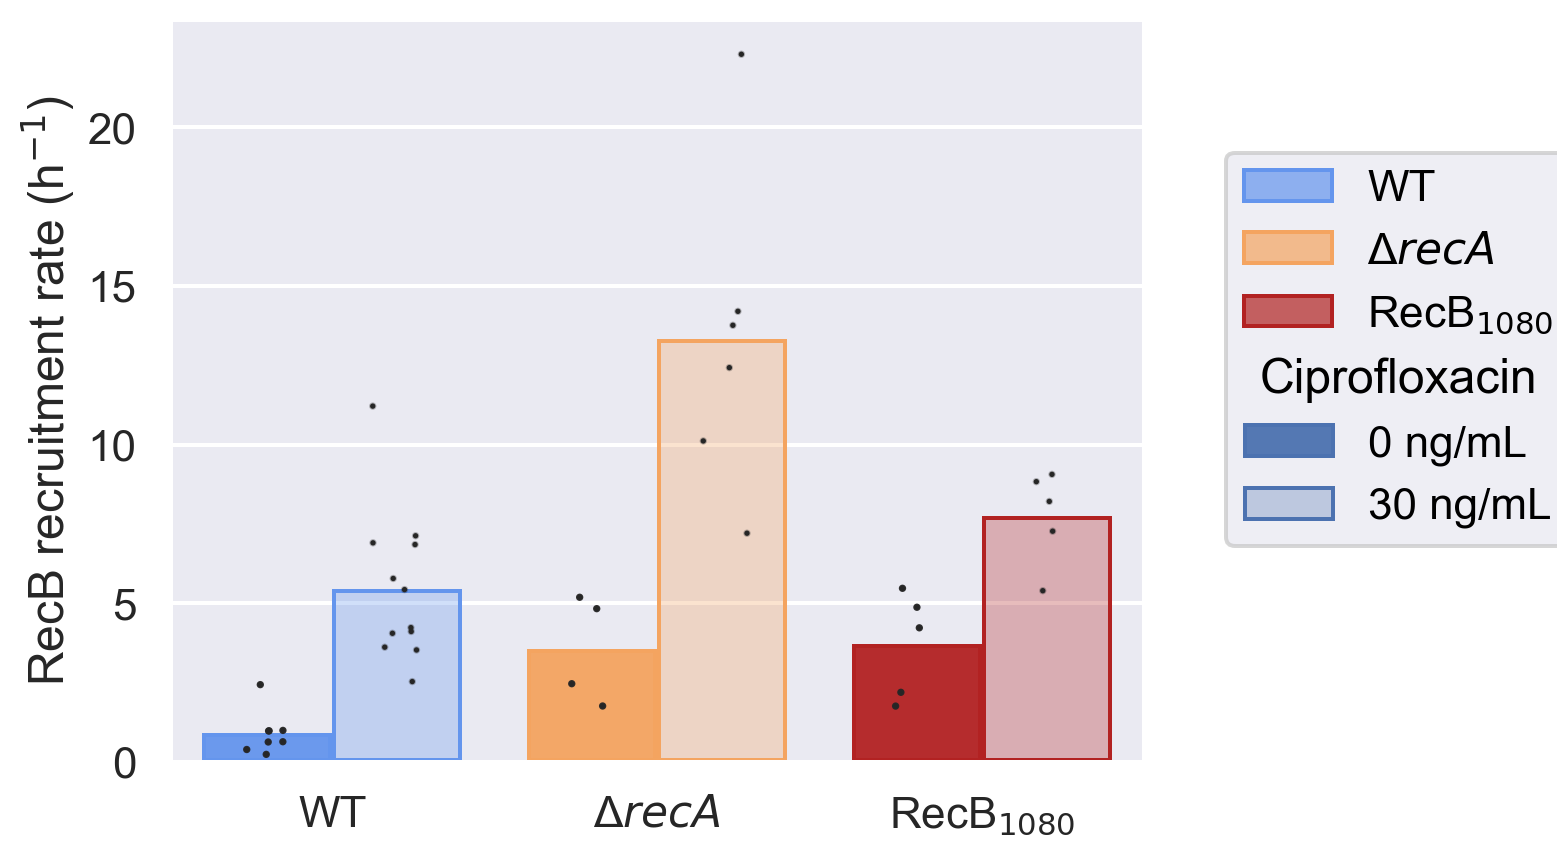

In [10]:
df = (data
      .RecB_spots
      .query('Time_min_bin < 90 and Frame > 0')
      .groupby(by=['Group', 'Dataset', 'ParentIndices'])
      .agg({'Indices': 'count'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .groupby(by=['Group', 'Dataset'])
      .agg({'SpotCount': 'sum'})
      .reset_index()
      .merge(data
             .Bacteria_large
             .groupby(['Dataset'])
             .agg({'Position':'count'})
             .reset_index()
             .rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset'],
             suffixes=('_old', None)
             )
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.SpotCount / df.nCells
              )
      .merge(lifetimes_biexp
             .query('Parameter == "Population" and Rate_type == "Long"')
             .rename(columns={'value':'long_lived'})
             .assign(long_lived=lambda df: (df.long_lived)/100),  # Subtract long-lived population in Gam data
             on=['Group', 'Dataset']
             )
      .assign(DSB_rate=lambda df: df.norm_count /98*60*60 *df.long_lived)  # Rate of DSB formation (h-1)
      )

display(df
        .assign(Strain=lambda df: df.Strain
                                   .astype('category')
                                   .cat.set_categories(['WT', 'Δ$recA$', 'RecB1080'], ordered=True))
        .sort_values('Strain')
        .groupby(['Strain', 'Cipro'], observed=True)
        .agg({'DSB_rate':['mean', 'std']})
        .round(1)
        )

(
    so.Plot(df, x='Strain', y='DSB_rate', color='Strain', alpha='Cipro')
    .add(so.Bar(), so.Agg(), so.Dodge(by=['alpha']))
    .add(so.Dots(color='k', fillalpha=1, marker='.'), so.Jitter(), so.Dodge(by=['alpha']), legend=False)
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick'], order=['WT', 'Δ$recA$', 'RecB$_{1080}$']),
           x=so.Nominal(order=['WT', 'Δ$recA$', 'RecB$_{1080}$'])
           )
    .share(y=False)
    .limit(y=(0, None))
    .label(x="", y="RecB recruitment rate (h$^{-1}$)", alpha='Ciprofloxacin', color='')
    .theme(plotting_context('talk'))
#     .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/4_Mutants/Recruitment_rates.svg', format='svg', bbox_inches='tight')
)